## **Data Cleaning**

In this notebook, we’ll go through the **first step of data preprocessing — cleaning the data**

Real-world datasets are rarely perfect. They often contain:

- Missing values (e.g., a person’s age not recorded)

- Duplicates (same record appearing more than once)

- Inconsistent values (typos, wrong formats)

- Outliers (unusual data points that may affect the model)

If we don’t fix these issues, machine learning models may learn incorrect patterns and give poor results.

What we’ll do in this notebook

- Detect and handle missing values

- Remove duplicates

- Identify and treat outliers

- Make the dataset consistent and ready for analysis

By the end, we’ll have a clean, reliable dataset that can be used for further preprocessing and modeling.

In [ ]:
from sklearn.datasets import fetch_openml
import pandas as pd

adult = fetch_openml(name="adult", version=2, as_frame=True)

df_adult = adult.frame

df_adult.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             48842 non-null  int64   
 1   workclass       46043 non-null  category
 2   fnlwgt          48842 non-null  int64   
 3   education       48842 non-null  category
 4   education-num   48842 non-null  int64   
 5   marital-status  48842 non-null  category
 6   occupation      46033 non-null  category
 7   relationship    48842 non-null  category
 8   race            48842 non-null  category
 9   sex             48842 non-null  category
 10  capital-gain    48842 non-null  int64   
 11  capital-loss    48842 non-null  int64   
 12  hours-per-week  48842 non-null  int64   
 13  native-country  47985 non-null  category
 14  class           48842 non-null  category
dtypes: category(9), int64(6)
memory usage: 2.7 MB


In [ ]:
df_adult.shape

(48842, 15)

In [ ]:
# Check first rows
df_adult.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


It is given in the documentation for the dataset that fnlwgt is a sampling column(not an actual feature). Therefore its better to drop it

In [ ]:
df_adult=df_adult.drop(columns=['fnlwgt'])

### **Handling Missing Values**

In real-world datasets, it’s very common to have some missing or blank entries. For example, in a survey dataset, a person might choose not to answer a question like “income” or “workclass.”

Why does it matter?

- Most machine learning algorithms cannot handle missing values directly.

- If we ignore them, the model may fail to train or give unreliable results.

- Too many missing values can reduce the amount of usable data, which weakens the model.

So, instead of just leaving them as blanks, we use different strategies to handle them.

**How do we handle them?**

There is no “one-size-fits-all” method—it depends on the amount and type of missing data. Some common strategies are:

- Drop rows or columns

    - If only a very small number of rows are missing values, we can remove them without losing much information.

    - Similarly, if an entire column has too many missing values, sometimes it’s better to drop it.

- Imputation (filling in values)

    - Numerical features: Fill missing values with the mean or median of the column.

        - Mean is good when the data is evenly distributed.

        - Median is better if the column has outliers.

    - Categorical features: Replace missing values with the most frequent (mode) value.

- Special category for missing values

    - For categorical columns, we can add a new label like "Unknown" or "Missing".

    - This is useful when missingness itself might carry information (e.g., people not reporting occupation could have a pattern).

In [ ]:
df_adult.isnull().sum()

,0
age,0
workclass,2799
fnlwgt,0
education,0
education-num,0
marital-status,0
occupation,2809
relationship,0
race,0
sex,0


Applying it to this dataset

- native-country → Has about 857 missing values (~2% of data). This is small, so we can safely fill it with the most common country (mode).

- workclass and occupation → Each has ~6% missing values. Instead of dropping these rows (which would throw away a lot of data), we can fill them with a new category "Unknown". This way, we don’t lose information, and the model can learn from it.

In [ ]:
# Convert columns to object type before filling null values
df_adult['workclass'] = df_adult['workclass'].astype('object')
df_adult['occupation'] = df_adult['occupation'].astype('object')

# Filling in Unknown for occupation and workclass
df_adult['workclass'] = df_adult['workclass'].fillna('Unknown')
df_adult['occupation'] = df_adult['occupation'].fillna('Unknown')

In [ ]:
#Filling the native-country column with mode
df_adult['native-country'] = df_adult['native-country'].fillna(df_adult['native-country'].mode()[0])

### **Removing Duplicate Values**

Sometimes, datasets contain duplicate rows, meaning the exact same entry appears more than once.
For example, if two identical records of the same person are present, the dataset is giving them more importance than others.

**Why does it matter?**

- Duplicates can bias the model by giving extra weight to certain records.

- This reduces fairness and may affect predictions.

- Cleaning duplicates ensures every observation is unique and treated equally.

**How do we handle them?**

- Detect and remove duplicates.

- Keep only the first occurrence (or the most relevant one if the dataset has timestamps).

In [ ]:
df_adult.drop_duplicates(inplace=True)

In [ ]:
df_adult.shape

(48790, 15)

### **Detecting Outliers**

**What are outliers?**
Outliers are extreme values that don’t fit the normal pattern of data. For example:

- A person working 200 hours per week

- Someone with an income of 10 million in a dataset where most incomes are under 100k

Outliers can appear for two reasons:

- **Errors in data entry or measurement** → e.g., a person’s age recorded as 500.

- **Genuine rare cases** → e.g., someone earning very high income compared to others.

If outliers are errors, they should be removed. But if they are real values, they might still carry important information. That’s why we need to carefully analyze outliers before deciding what to do.

#### **Method 1 : Data Visualization**
The easiest way to spot outliers is by visualizing the data (for example, using a boxplot or histogram).

- A boxplot shows the spread of data and highlights values that fall far from the rest.

- For example, when plotting the age column, we can quickly see if some ages are much higher or lower than most others.

Visualization helps us get an intuition about whether unusual values look like mistakes or valid rare cases.

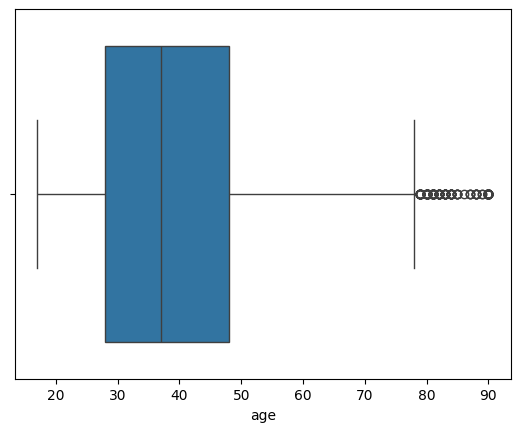

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x=df_adult['age'])
plt.show()

We can see here that people in the age group 80–90 are flagged as outliers. This happens because they are relatively rare compared to the rest of the population.

However, this is not a data entry mistake—it’s simply a valid but less common case (some people really do live and work into their 80s and 90s).

In such situations, we keep the values instead of removing them, since they represent real-world diversity.

#### **Method 2: Using Summary Statistics**
Another common way to detect outliers is by using the **Interquartile Range (IQR)**.
- Calculate the Interquartile Range 

$$
\text{IQR} = Q3 – Q1
$$ 

- Define thresholds:

$$
\text{Lower bound}= Q1-  1.5 X  IQR
$$

$$
\text{Upper bound}=Q3+ 1.5 XIQR
$$

Any value outside this range is considered an outlier

This method is useful because it works for many distributions without making assumptions about the data.

In [ ]:
numeric_cols = df_adult.select_dtypes(include=['int64', 'float64']).columns

for col in numeric_cols:
    Q1 = df_adult[col].quantile(0.25)
    Q3 = df_adult[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df_adult[(df_adult[col] < lower) | (df_adult[col] > upper)]
    print(f"{col}: {outliers.shape[0]} outliers")



age: 215 outliers
education-num: 1787 outliers
capital-gain: 4035 outliers
capital-loss: 2282 outliers
hours-per-week: 13486 outliers


**Column-wise Observations**

- **hours-per-week:**
Most people work around 40 hours per week, but some work 60–90. These are not mistakes — they are valid, just less common. We should keep them.

- **education-num:**
This column represents years of education, mapped into categories between 1 and 16. Since the range is fixed, values outside this are unlikely. Outliers here are usually not errors but edge cases.

- **capital-gain:**
Highly skewed — most people have 0, but a few have very high values. These are genuine rare high-income cases. Dropping them would lose important information.

- **capital-loss:**
Same reasoning as capital-gain. Most values are 0, with a few large ones that are valid.

**What to do with outliers?**

- **In many datasets:** Outliers are dropped because they can add noise and reduce model accuracy.

- **In this dataset:** Some “outliers” are actually real rare cases (e.g., high capital gains/losses, long working hours). Dropping them would remove valuable information.

Instead of dropping, we apply a log transformation:

**Log Transformation**

- Log reduces the scale of very large numbers while keeping their relative differences intact.

- Example: instead of values like 0, 5000, 10000, 20000, after log we get much smaller, compressed values.

- This way, the influence of extreme values is reduced, but we don’t lose the data.

**Final Note:** Outlier handling is not about blindly removing unusual values. It’s about understanding the data and deciding whether those values are mistakes or important rare cases. In our case, we keep them and use log transformation to make the model handle them better.

In [ ]:
import numpy as np
import pandas as pd

print(df_adult['capital-gain'].describe())

# Apply log transform
df_adult['capital-gain'] = np.log1p(df_adult['capital-gain'])

print(df_adult['capital-gain'].describe())

count    48790.000000
mean      1080.217688
std       7455.905921
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      99999.000000
Name: capital-gain, dtype: float64
count    48790.000000
mean         0.729321
std          2.446667
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         11.512925
Name: capital-gain, dtype: float64


In [ ]:
import numpy as np
import pandas as pd

print(df_adult['capital-loss'].describe())

# Apply log transform
df_adult['capital-loss'] = np.log1p(df_adult['capital-loss'])

print(df_adult['capital-loss'].describe())

In [ ]:
df_adult.to_csv("adult_cleaned.csv", index=False)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Now our dataset is cleaned - with missing values handled, duplicates removed and outliers treated- the data is trustworthy. The next step is to perform some **exploratory data analysis** to understand our data and gain insights from it 